In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables


C:\Users\jtran\AppData\Local\Temp\ipykernel_20704\3559592862.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

<Figure size 1000x600 with 0 Axes>

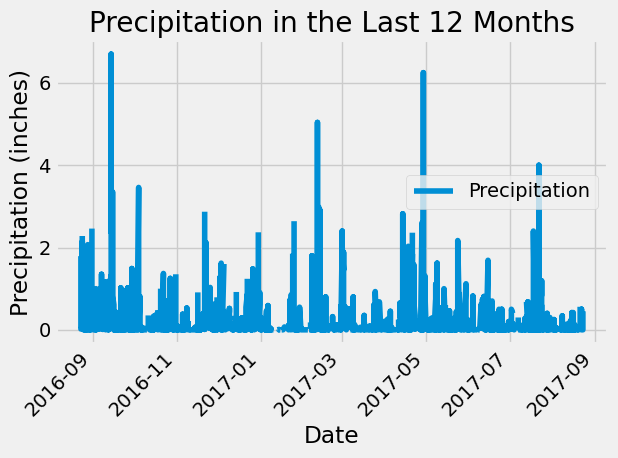

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()
# Calculate the date one year from the last date in data set.
last_year_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - pd.DateOffset(years=1)
last_year_date_str = last_year_date.strftime('%Y-%m-%d')  # Convert to string format

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year_date_str).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=["Date", "Precipitation"])

# Sort the dataframe by date
df["Date"] = pd.to_datetime(df["Date"])  # Ensure the date is in datetime format
df = df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
df.plot(x="Date", y="Precipitation", kind="line", title="Precipitation in the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = df["Precipitation"].describe()

# Print the summary statistics
print(precipitation_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.id)).scalar()
total_stations

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    Station.station, func.count(Measurement.station).label('count')
).join(Measurement, Station.station == Measurement.station).group_by(Station.station).order_by(func.count(Measurement.station).desc()).all()

# Print the stations and their counts in descending order
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [15]:
# Assuming the most active station is the first result from the previous query
most_active_station_id = most_active_stations[0][0]  # Get the station id

# Perform the query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station_id).all()

# Print the results
min_temp, max_temp, avg_temp = temperature_stats[0]
print(f"Station {most_active_station_id} - Min Temp: {min_temp}, Max Temp: {max_temp}, Avg Temp: {avg_temp}")


Station USC00519281 - Min Temp: 54.0, Max Temp: 85.0, Avg Temp: 71.66378066378067


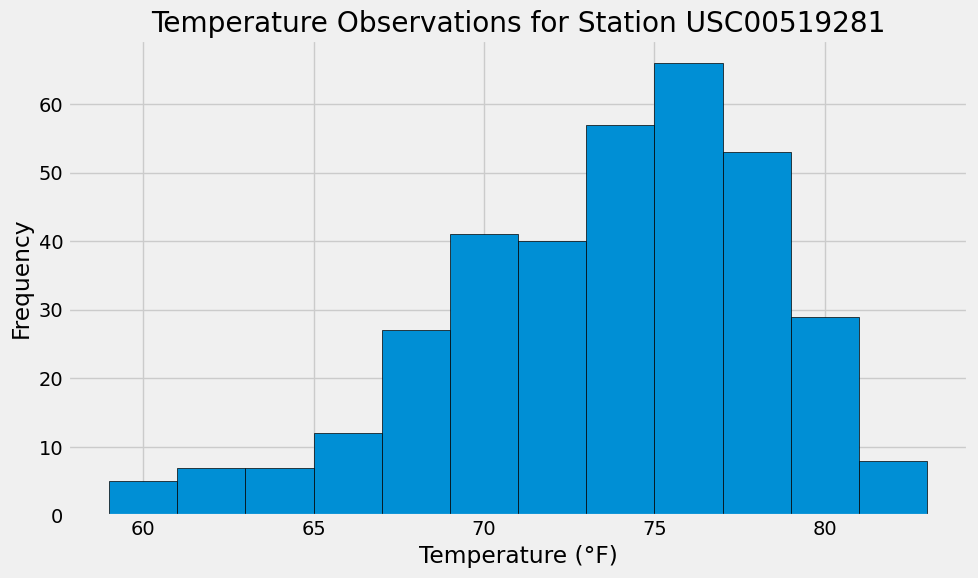

In [16]:
# Step 2: Calculate the date one year from the most recent observation
most_recent_date = session.query(func.max(Measurement.date)).scalar()
last_year_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - pd.DateOffset(years=1)
last_year_date_str = last_year_date.strftime('%Y-%m-%d')  # Convert to string format

# Step 3: Perform the query to retrieve the temperature data for the last 12 months
results = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= last_year_date_str
).all()

# Step 4: Convert the results to a Pandas DataFrame for easier manipulation
df = pd.DataFrame(results, columns=["Temperature"])

# Step 5: Plot the histogram
plt.figure(figsize=(10, 6))
df["Temperature"].plot(kind="hist", bins=12, edgecolor='black', title=f"Temperature Observations for Station {most_active_station_id}")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [17]:
# Close Session
session.close()